## Boosting Decision Stumps

In this notebook, you will use [scikit-learn's decision trees](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) 
and implement the AdaBoost algorithm for binary classification. In particular, you will

1. Implement AdaBoost and evaluate its performance on a toy dataset
2. Investigate the effect of number of iterations/tree depth

The exercise is mostly based on the lecture and the following book:

T. Hastie, R. Tibshirani, and J. Friedman: [*The Elements for Statistical Learning*](http://statweb.stanford.edu/~tibs/ElemStatLearn/), 2001

As usual, some setup first:

In [1]:
import sklearn.datasets
import sklearn.tree
import sklearn.base
import sklearn.metrics
import sklearn.ensemble

import numpy as np

import matplotlib.pyplot as plt

/home/eggenspk/anaconda3/envs/general_36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The data set is an example from [scikit-learn's datasets submodule](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_hastie_10_2.html) which was introduced by [Hastie, Tibshirani and Friedman]. It has 10 features, which are standard independent Gaussian. The deterministic target Y is defined with:

```   y[i] = 1 if np.sum(X[i] ** 2) > 9.34 else -1```

In [2]:
# Create a binary classification dataset
def create_dataset():
    num_samples=12000
    n_train = 2000
    
    X, y = sklearn.datasets.make_hastie_10_2(n_samples=num_samples, 
                                             random_state=1)
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]
    return X_train, y_train, X_test, y_test

In [3]:
class AdaBooster(object):
    
    def __init__(self, weak_learner, iterations):
        '''
        weak_learner: sklearn classifier - G_m
        iterations: number of iteration to train - M
        '''
        self.weak_learner = weak_learner
        self.iterations = iterations
        
        # 1. Initialize some more lists
        self.classifiers = list() # trained classifiers G_m
        self.alphas = list()      # classifier weights       
    
    def fit(self, X, y):
        # YOUR TURN
        # 1. initialize the observation weights
        w = np.ones_like(y) / X.shape[0]
        
        # 2. For m=1 to M
        for it in range(self.iterations):
            # hint: Use sklearn.base.clone method to copy the 
            #       classifier in each iteration. Only 'clones'
            #       the class, not the model. 

            # (a) Fit a classifier
            tmp_learner = sklearn.base.clone(self.weak_learner)
            tmp_learner.fit(X, y, sample_weight=w)
            self.classifiers.append(tmp_learner)
            
            # (b) Compute error
            y_pred = tmp_learner.predict(X)
            error = np.sum(w * (y != y_pred))
            error /= np.sum(w)

            # (c) Compute classifier weight
            alpha = np.log((1 - error) / error)
            self.alphas.append(alpha)

            # (d) Update observation weights
            w *= np.exp(alpha * (y != y_pred))
    
    def predict(self, X):
        # Compute predictions by looping over all classifiers 
        # and adding weighted predictions. 
        # The actual output should be 
        # -1 if y_i <= 0 and 1 otherwise
    
        # YOUR TURN
        pred = np.zeros(X.shape[0])
        for alpha, c in zip(self.alphas, self.classifiers):
            tmp_pred = c.predict(X)
            pred += alpha * tmp_pred
        pred[pred > 0] = 1
        pred[pred <= 0] = -1
        return pred
    
    def staged_predict(self, X):
        # returns predictions for X for all iterations 
        # this is for convenience to simplify computing
        # train/test error for all iterations

        staged_predictions = []
        pred = np.zeros(X.shape[0])
        for alpha, c in zip(self.alphas, self.classifiers):
            tmp_pred = c.predict(X)
            pred += alpha * tmp_pred
            
            staged_prediction = pred.copy()
            staged_prediction[staged_prediction > 0] = 1
            staged_prediction[staged_prediction <= 0] = -1            
            staged_predictions.append(staged_prediction)
            
        return staged_predictions

### Test your implementation

Now, you have a working implementation of the AdaBoost algorithm. To test your algorithm for correctness you can compare to [sklearns AdaBoost implementation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) which should yield the same output as your implementation:

In [10]:
# Use this cell to test whether your implementation is correct

weak_learner = sklearn.tree.DecisionTreeClassifier(max_depth=1)
adaboost = AdaBooster(weak_learner=weak_learner, iterations=400)
sk_adaboost = sklearn.ensemble.AdaBoostClassifier(weak_learner, 
                                                  algorithm="SAMME", 
                                                  n_estimators=400)

# Get data
X_train, y_train, X_test, y_test = create_dataset()

# Fit model
adaboost.fit(X_train, y_train)
sk_adaboost.fit(X_train, y_train)

# Predict
pred = adaboost.predict(X_test)
pred_sk = sk_adaboost.predict(X_test)

print("Difference: %d" % np.sum([pred != pred_sk]))

Difference: 0


### Playground

Next, you can play around with AdaBoost's hyperparameters. Here are some suggestions:

 * Investigate the number of iterations that are needed to start overfitting.
 * Add some noise on the targets and try again.
 * Investigate the effect of the tree depth.
 
Before you investigate the model it will be helpful to prepare a function that generates a plot showing
test/train performance over number of iterations:

In [5]:
def plot_train_test_error(model, X_train, y_train, X_test, y_test):
    ''' Shows a plot with train/test error over iterations

    model (AdaBooster): trained AdaBoost algorithm
    X_train (array): [#samples, #features]
    y_train (array): [#samples, ]
    X_test (array): [#samples, #features]
    y_test (array): [#samples, ]
    '''
    # Loop over all predictions and compute accuracy
    y_pred_train = model.staged_predict(X_train)
    training_errors = [1-sklearn.metrics.accuracy_score(y_train, y_pred) 
                       for y_pred in y_pred_train]
    
    y_pred_test = model.staged_predict(X_test)
    test_errors = [1-sklearn.metrics.accuracy_score(y_test, y_pred) 
                   for y_pred in y_pred_test]
    
    # Plot results
    x_values = np.arange(1, len(training_errors) + 1)

    plt.plot(x_values, training_errors, label="training")
    plt.plot(x_values, test_errors, label="test")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    plt.legend(loc="best")
    plt.ylim([0, 1.1])
    
    #plt.show()

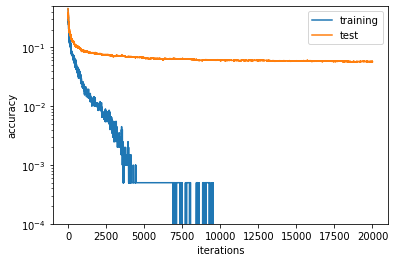

In [17]:
# Investigate overfitting and find out number of iterations 
# needed to overfit
# --> The train and test error diverge after roughly ~100 
# iterations. While the training error goes down to 0 
# (after ~2000 iterations), the test accuracy does not decrease anymore.

# YOUR TURN

# Get data
X_train, y_train, X_test, y_test = create_dataset()

# Instantiate model
weak_learner = sklearn.tree.DecisionTreeClassifier(max_depth=1)
adaboost = AdaBooster(weak_learner=weak_learner, iterations=20000)

# Fit model
adaboost.fit(X_train, y_train)
pred = adaboost.predict(X_test)

# Evaluate model
plot_train_test_error(adaboost, X_train, y_train, X_test, y_test)
plt.ylim([0.0001, 0.5])
plt.yscale('log')

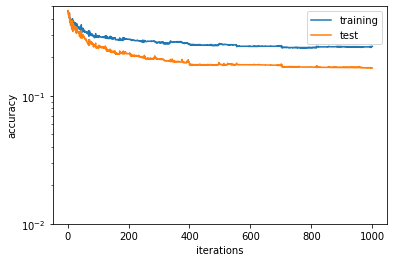

In [15]:
# Add some noise on the data and try again
# --> Changing 0.01 of all y-values does not harm the prediction, 
# a higher noise decreases training accuracy 

# Get data
X_train, y_train, X_test, y_test = create_dataset()
swap_ratio = 0.2
swap_idx = list(range(0, y_train.shape[0]))
np.random.shuffle(swap_idx)
y_train[swap_idx[:int(y_train.shape[0]*swap_ratio)]] *= -1

# Instantiate model
weak_learner = sklearn.tree.DecisionTreeClassifier(max_depth=1)
adaboost = AdaBooster(weak_learner=weak_learner, iterations=1000)

# Fit model
adaboost.fit(X_train, y_train)
pred = adaboost.predict(X_test)

# Evaluate model
plot_train_test_error(adaboost, X_train, y_train, X_test, y_test)
plt.ylim([0.01, 0.5])
plt.yscale('log')

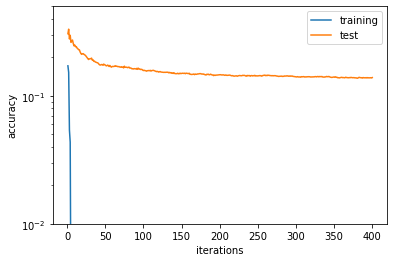

In [16]:
# Investigate the effect of the tree depth
# Outcome: Using simple learners allow to still learn a complex function. 
# Using a stronger base model increases the gap between train/test 
# performance

# Get data
X_train, y_train, X_test, y_test = create_dataset()

# Instantiate model
weak_learner = sklearn.tree.DecisionTreeClassifier(max_depth=10)
adaboost = AdaBooster(weak_learner=weak_learner, iterations=400)

# Fit model
adaboost.fit(X_train, y_train)
pred = adaboost.predict(X_test)

# Evaluate model
plot_train_test_error(adaboost, X_train, y_train, X_test, y_test)
plt.ylim([0.01, 0.5])
plt.yscale('log')